# Exercise 06
# TensorFlow and Keras

### Nelson Andrés Rozo Cruz. Código: 201728031

----


In [3]:
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons

%matplotlib inline

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1. Multilayer neural network in TensorFlow

You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

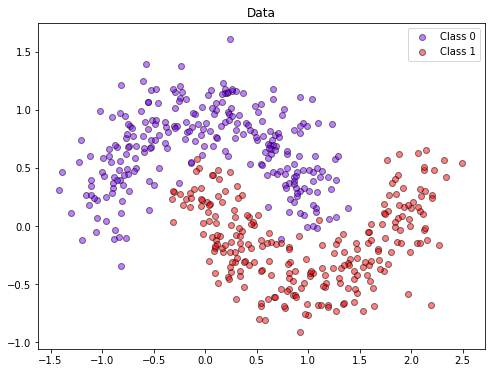

In [4]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models 
such as those in `tf.estimator`. **Hint**: extend the logistic regression example from the TensorFlow handout. 

Your answer must contain the following:
* A visualization of the CG of the model.
* A visualization of the decision region along with the test data.
* A snapshot from TensorBoard that shows the evolution of the training and test loss.

In [5]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline


# Helper functions to inline visualization of computing graphs
# Extracted from: 
# https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= -1, vmax=2)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

In [91]:
numn=20

graph = tf.Graph()
with graph.as_default():
    
    x = tf.placeholder(tf.float32,shape=[None,2])
    y_true = tf.placeholder(tf.float32,shape=None)
    
    with tf.name_scope('hidden_layer') as scope: 
        w1 = tf.Variable(tf.random_normal([numn,2]),dtype=tf.float32,name='weights1')
        b1 = tf.Variable(tf.random_normal([numn,1]),dtype=tf.float32,name='bias1') 
        h = tf.sigmoid(tf.matmul(w1,tf.transpose(x)) + b1, name='sigmoid')
    
    with tf.name_scope('inference') as scope:
        w2 = tf.Variable(tf.random_normal([1,numn]),dtype=tf.float32,name='weights')
        b = tf.Variable(0,dtype=tf.float32,name='bias') 
        y_pred = tf.matmul(w2,h) + b

    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss)
  
    with tf.name_scope('train') as scope:
        learning_rate = 1
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

show_graph(graph.as_graph_def())

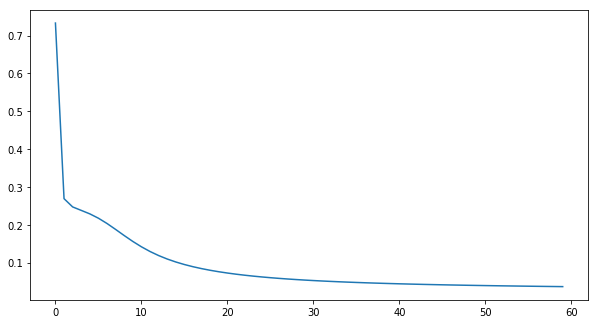

In [96]:
num_epochs = 3000
losses = []

with graph.as_default():
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        sess.run(train,{x: x_train, y_true: y_train})
        if (step % 50 == 0):
            losses.append(sess.run(loss, {x: x_train, y_true: y_train}))
                       
pl.figure(figsize = (10,16/3))
pl.plot(losses)

[[-1.3786428   1.1871271 ]
 [ 4.2311087   4.1153026 ]
 [ 3.4382248  -2.0960467 ]
 [-1.2319372   1.411218  ]
 [-1.0267928  -0.32687488]
 [-1.2275087  -0.5473584 ]
 [-7.215028   -2.2156045 ]
 [ 6.415618   -0.8483604 ]
 [-0.92531765  0.3879636 ]
 [ 1.561031   -1.892324  ]
 [ 6.419695   -1.7361592 ]
 [-1.0941074  -0.04566035]
 [-1.5296502   0.898692  ]
 [ 1.1923156  -1.1854451 ]
 [-2.5718038   1.6271893 ]
 [-1.0584513   0.37514454]
 [-0.1132215  -0.6843009 ]
 [-2.0195563   2.1414945 ]
 [ 3.9310482   3.032819  ]
 [ 1.2036605  -1.3729184 ]]
[[-18.482033]]


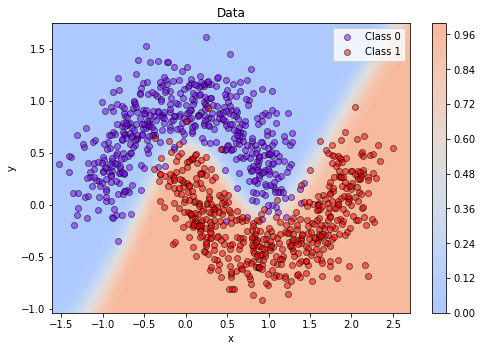

In [97]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

with graph.as_default():
    wval = sess.run(w1)
    print(wval)
    result = sess.run(y_pred, {x:np.array([[1,2]])})
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(x_train, pred_fun)
plot_data(X, Y)

### 2. Improving the Keras text classifier

Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

* Different activation functions for the hidden layer (https://keras.io/activations/)
* Different optimizers (https://keras.io/optimizers/)
* Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
* Different initializers for the dense layers (https://keras.io/initializers/)

Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?


In [3]:
import numpy as np

from keras.datasets import reuters
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer

max_words = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

C:\Users\Nrozo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading data...
8982 train sequences
2246 test sequences
46 classes


Is instance is represented by a sequence of numbers which correspond to indices of the corresponding words.

In [4]:
print(x_train[101])

[1, 2, 149, 8, 25, 2, 400, 304, 200, 6, 337, 4, 342, 2, 2, 7, 2, 2, 9, 4, 342, 643, 2, 7, 2, 4, 88, 2, 31, 4, 384, 292, 211, 5, 2, 978, 220, 33, 851, 2, 11, 15, 9, 447, 7, 42, 92, 131, 276, 5, 156, 11, 15, 50, 33, 30, 2, 7, 2, 383, 29, 336, 25, 383, 29, 2, 94, 156, 4, 49, 8, 7, 788, 4, 88, 33, 2, 747, 11, 15, 197, 92, 222, 825, 5, 934, 11, 15, 2, 8, 17, 12]


In [5]:
print(len(x_train[101]))    

92


The map for word to index is also provided, so it is possible to decode the instance back to text:

In [6]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
num_words = max(word_index.values()) + 1
words = ['']*num_words
for word in word_index:
    words[word_index[word]] = word
print([words[i-2] for i in x_train[101][1:]])

['', 'dlr', 'and', 'cts', '', '80', 'average', 'companies', 'in', 'income', 'of', 'make', '', '', 'said', '', '', 'a', 'of', 'make', '52', '', 'said', '', 'of', '1987', '', '2', 'of', 'sold', 'general', 'states', 'to', '', 'field', 'securities', 'was', 'agricultural', '', '3', 'it', 'a', '1988', 'said', 'as', 'april', '50', 'term', 'to', 'earlier', '3', 'it', 'but', 'was', 'with', '', 'said', '', 'previously', 'be', 'sell', 'cts', 'previously', 'be', '', 'more', 'earlier', 'of', 'which', 'and', 'said', 'commerce', 'of', '1987', 'was', '', 'august', '3', 'it', 'export', 'april', 'report', 'vice', 'to', 'beef', '3', 'it', '', 'and', '000', 'for']


Data is encoded using a bag of words representation, i.e. a matrix of size num of instances by vocabulary size

In [7]:
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 1000)
x_test shape: (2246, 1000)


Labels are converted to one-hot representation:

In [8]:
import keras

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


Now we build a dense neural network with one hidden layer:

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout

from keras.initializers import Zeros
from keras.initializers import Ones
from keras.initializers import Constant
from keras.initializers import RandomNormal
from keras.initializers import RandomUniform
from keras.initializers import TruncatedNormal
from keras.initializers import VarianceScaling
from keras.initializers import Orthogonal
from keras.initializers import lecun_uniform
from keras.initializers import glorot_normal
from keras.initializers import glorot_uniform
from keras.initializers import he_normal

model = Sequential()
model.add(Dense(256, input_shape=(max_words,),kernel_initializer='RandomNormal'))
model.add(Activation('softsign'))
model.add(Dropout(0))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_1 (Dense)                (None, 256)                 256256     
______________________________________________________________________
activation_1 (Activation)      (None, 256)                 0          
______________________________________________________________________
dropout_1 (Dropout)            (None, 256)                 0          
______________________________________________________________________
dense_2 (Dense)                (None, 46)                  11822      
______________________________________________________________________
activation_2 (Activation)      (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


We configure the learning task to use SGD as optimization:

In [11]:
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import TFOptimizer

model.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

Now we can train the model using a 0.1 training validation split:

In [116]:
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 5s 663us/step - loss: 1.0467 - acc: 0.7641 - val_loss: 0.9104 - val_acc: 0.7976
Epoch 2/5
8083/8083 [==============================] - 4s 492us/step - loss: 0.5413 - acc: 0.8802 - val_loss: 0.8772 - val_acc: 0.8154
Epoch 3/5
8083/8083 [==============================] - 2s 289us/step - loss: 0.4180 - acc: 0.9071 - val_loss: 0.8562 - val_acc: 0.8165
Epoch 4/5
8083/8083 [==============================] - 2s 216us/step - loss: 0.3484 - acc: 0.9228 - val_loss: 0.8644 - val_acc: 0.8120
Epoch 5/5
8083/8083 [==============================] - 2s 188us/step - loss: 0.2999 - acc: 0.9323 - val_loss: 0.8794 - val_acc: 0.8042


Finally, we test the performance over the test set:

In [117]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 204us/step
Test score: 0.8635481928250456
Test accuracy: 0.8005342831700801


_____________
#### The initial accuracy was 0.5282 and it is the reference to evaluate other results. First of all, I evaluated each variable to have the individual performance.

### 1 ACTIVATION
#### selu = 0.7186,   linear = 0.7012,   tanh = 0.6954,   elu = 0.6905,   relu = 0.6740,   softsign = 0.6638,   sigmoid = 0.5258,   hard_sigmoid = 0.5102,   softmax = 0.3619

### 2 OPTIMIZERS
####  Adagrad = 0.7956, Adadelta = 0.7916, RMSprop = 0.7889, Adam = 0.7800, Adamax = 0.7764, Nadam = 0.7738, SGD = 0.5258

### 3 DROPOUT
####  Dropout(0) = 0.5258, Dropout(0.2) = 0.5057, Dropout(0.4) = 0.5115, Dropout(0.6) = 0.5017, Dropout(0.8) = 0.4131, Dropout(1) = 0.5258

### 4 INITIALIZER
#### Zeros = 0.5129 , Ones = 0.3619 , Constant = 0.5195 , RandomNormal = 0.5405 , RandomUniform = 0.5282 , TruncatedNormal = 0.5284 , VarianceScaling = 0.5258 , Orthogonal = 0.5227 , lecun_uniform = 0.5316 , glorot_normal = 0.5213 , glorot_uniform = 0.5213 , he_normal = 0.5231

#### After first step, I evaluated the conbinated model. Finally, the better combination is given by Activation = "Selu", Optimizers = "Adagrad" and Initializer not equal to "Ones". Dropout has not importance to change the accuracy. The model good performance is given basically for the Optimier Adagrad.

#### Accuracy of combinated model = 0.8103
  * Activation: selu
  * Optimizers: RMSprop
  * Dropout: 0.6
  * Initializer: RandomNormal

#### Code used is as follows.

In [15]:
Comb=["","","","",0]

Optim=RMSprop

for Activ in ["selu","tanh","linear","elu","relu","softsign","sigmoid","hard_sigmoid","softmax"]:
    for Dropo in [0.6,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
        for Initia in ["Zeros","Ones","Constant","RandomNormal","RandomUniform","TruncatedNormal","VarianceScaling","Orthogonal",
                       "lecun_uniform","glorot_normal","glorot_uniform","he_normal"]:
            
            model = Sequential()
            model.add(Dense(256, input_shape=(max_words,),kernel_initializer=Initia))
            model.add(Activation(Activ))
            model.add(Dropout(Dropo))
            model.add(Dense(num_classes))
            model.add(Activation('softmax'))
            model.summary(70)
            
            model.compile(loss='categorical_crossentropy',
                          optimizer=Optim(),
                          metrics=['accuracy'])
            
            batch_size = 32
            epochs = 5
            history = model.fit(x_train, y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_split=0.1)
            
            score = model.evaluate(x_test, y_test)
            accuracy = score[1]
            
            print(Activ,Optim,Dropo,Initia,accuracy)

            if accuracy >= Comb[4]:
                Comb=[Activ,Optim,Dropo,Initia,accuracy]
            Comb=Comb
            
print(Comb)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_9 (Dense)                (None, 256)                 256256     
______________________________________________________________________
activation_9 (Activation)      (None, 256)                 0          
______________________________________________________________________
dropout_5 (Dropout)            (None, 256)                 0          
______________________________________________________________________
dense_10 (Dense)               (None, 46)                  11822      
______________________________________________________________________
activation_10 (Activation)     (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________
Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [========